In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms, models
from copy import deepcopy

from torchvision.datasets import ImageFolder
from sklearn import metrics

# Hyper-parameter

In [ ]:
config = {
    'train_ratio': 0.8,
    'batch_size': 32,
    'n_epochs': 3,
    'model': 'ResNet18',
    'verbose': 1
}

# utils

In [ ]:
def get_loaders(config, input_size, is_train=True):
  if is_train:
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),             
        transforms.ToTensor(),                           
    ])

    dataset = ImageFolder(root='/content/drive/MyDrive/딥러닝 강의자료/2023_1학기_딥러닝_강의자료/7주차/archive/train',            
                          transform=train_transform) 
  
    train_cnt = int(len(dataset)*config['train_ratio'])
    valid_cnt = len(dataset) - train_cnt
  
    train_dataset, valid_dataset = random_split(dataset, [train_cnt, valid_cnt])
    print("# of train_dataset : ", len(train_dataset))
    print("# of valid_dataset : ", len(valid_dataset))
    print(dataset.class_to_idx)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'])

    return train_loader, valid_loader
    
  else:
    test_transform = transforms.Compose([
        transforms.Resize((224,224)),                
        transforms.ToTensor(),                           
    ])

    test_dataset = ImageFolder(root='/content/drive/MyDrive/딥러닝 강의자료/2023_1학기_딥러닝_강의자료/7주차/archive/test',            
                        transform=test_transform) 
    print("# of test_dataset : ", len(test_dataset))
    print(test_dataset.class_to_idx)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'])

    return test_loader

# trainer

In [ ]:
class Trainer():

  def __init__(self, model, optimizer, crit):
      self.model = model
      self.optimizer = optimizer
      self.crit = crit

      super().__init__()

  def _train(self, train_loader, config):
      self.model.train()

      total_loss = 0

      for i, (x_i, y_i) in enumerate(train_loader):
          y_hat_i = self.model(x_i)
          loss_i = self.crit(y_hat_i, y_i.squeeze())

          # Initialize the gradients of the model.
          self.optimizer.zero_grad()
          loss_i.backward()

          self.optimizer.step()
          
          if config['verbose'] >= 2:
              print("Train Iteration(%d/%d): loss=%.4e" % (i + 1, len(train_loader), float(loss_i)))

          # Don't forget to detach to prevent memory leak.
          total_loss += float(loss_i)

      return total_loss / len(train_loader)

  def _validate(self, valid_loader, config):
      # Turn evaluation mode on.
      self.model.eval()

      # Turn on the no_grad mode to make more efficintly.
      with torch.no_grad():
          total_loss = 0

          for i, (x_i, y_i) in enumerate(valid_loader):
              y_hat_i = self.model(x_i)
              loss_i = self.crit(y_hat_i, y_i.squeeze())
              
              if config['verbose'] >= 2:
                  print("Valid Iteration(%d/%d): loss=%.4e" % (i + 1, len(valid_loader), float(loss_i)))

              total_loss += float(loss_i)

          return total_loss / len(valid_loader)

  def train(self, train_loader, valid_loader, config):
      lowest_loss = np.inf
      best_model = None

      for epoch_index in range(config['n_epochs']):
          train_loss = self._train(train_loader, config)
          valid_loss = self._validate(valid_loader, config)

          # You must use deep copy to take a snapshot of current best weights.
          if valid_loss <= lowest_loss:
              lowest_loss = valid_loss
              best_model = deepcopy(self.model.state_dict())

          print("Epoch(%d/%d): train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
              epoch_index + 1,
              config['n_epochs'],
              train_loss,
              valid_loss,
              lowest_loss,
          ))

      # Restore to best model.
      self.model.load_state_dict(best_model)


# train

In [ ]:
def main(config):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  train_loader, valid_loader = get_loaders(config, input_size=224, is_train=True)

  model = models.resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, 2)

  optimizer = optim.Adam(model.parameters())
  crit = nn.CrossEntropyLoss()

  if config['verbose'] >= 1:
    print(model)
    print(optimizer)
    print(crit)

  trainer = Trainer(model, optimizer, crit)
  trainer.train(train_loader, valid_loader, config)

  # Save best model weights
  torch.save({
      'model': trainer.model.state_dict(),
      'opt': optimizer.state_dict(),
      'config': config,
  }, config['model'] + '.pth')

In [ ]:
main(config)

# of train_dataset :  445
# of valid_dataset :  112
{'cats': 0, 'dogs': 1}


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 332MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# test

In [ ]:
model_fn = "./ResNet18.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def load(fn, device):
  d = torch.load(fn, map_location=device)
  
  return d['model'], d['config']

In [ ]:
def confusion_matrix(y_test, y_pred):
  cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))
  print("F1score:",metrics.f1_score(y_test, y_pred))



In [ ]:
def test(model, test_loader):
  model.eval()
  
  total_cnt, correct_cnt = 0, 0
  y_test_li, y_pred_li = np.array([]), np.array([])
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      correct_cnt += (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
      total_cnt += len(x)
      
      y_test_li = np.append(y_test_li, np.array(y.detach().cpu(), dtype='int'))
      y_pred_li = np.append(y_pred_li, np.array(torch.argmax(y_hat, dim=-1).detach().cpu(), dtype='int'))

    accuracy = correct_cnt / total_cnt
    print("Accuracy: %.4f" % accuracy)

    confusion_matrix(y_test_li, y_pred_li)

# of test_dataset :  140
{'cats': 0, 'dogs': 1}
Accuracy: 0.8714
Accuracy: 0.8714285714285714
Precision: 0.7954545454545454
Recall: 1.0
F1score: 0.8860759493670886


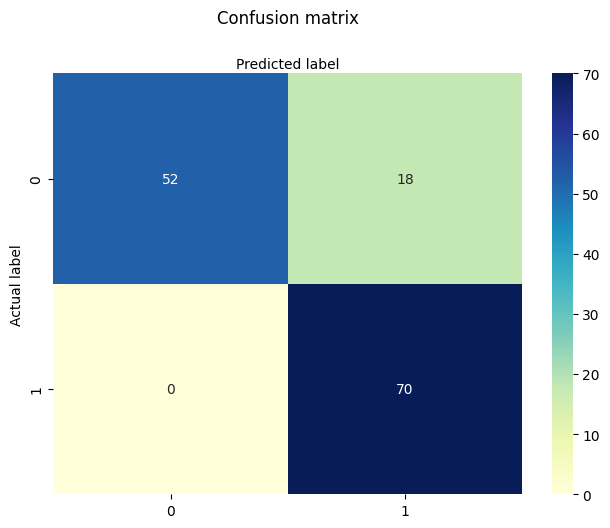

In [ ]:
model_dict, train_config = load(model_fn, device)

test_loader = get_loaders(config, input_size=224, is_train=False)
model = models.resnet18()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, 2)

model.load_state_dict(model_dict)

model.to(device)

test(model, test_loader)